In [1]:
# 'Cell 1: Imports and Configuration'
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import backend.processing_logic as processing_logic
import json
from datetime import datetime

# --- Configuration ---
# 将配置从web_server.py复制到这里，以便独立测试
YOLO_MODEL_PATH = 'backend/resource/yolov8n-seg.pt'
OLLAMA_API_URL = 'http://localhost:11434/api/generate'
DEEPSEEK_MODEL_NAME = 'deepseek-r1:8b'
TEST_IMAGE_PATH = 'backend/resource/bus.jpg'  # 默认图片路径
METADATA_PATH = 'backend/resource/capture_metadata.json'  # 存储拍摄时间的文件

print("Configuration set successfully.")
print(f"YOLO Model Path: {YOLO_MODEL_PATH}")
print(f"Ollama API URL: {OLLAMA_API_URL}")
print(f"DeepSeek Model: {DEEPSEEK_MODEL_NAME}")
print(f"Metadata Path: {METADATA_PATH}")

Configuration set successfully.
YOLO Model Path: backend/resource/yolov8n-seg.pt
Ollama API URL: http://localhost:11434/api/generate
DeepSeek Model: deepseek-r1:8b
Metadata Path: backend/resource/capture_metadata.json


In [2]:
# 'Cell 2: Load YOLO Model'
print("Loading YOLO model...")
try:
    yolo_model = YOLO(YOLO_MODEL_PATH)
    print(f"YOLO model '{YOLO_MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    yolo_model = None

Loading YOLO model...
YOLO model 'backend/resource/yolov8n-seg.pt' loaded successfully.


Image captured from webcam at 2025-06-30 15:13:39.
Metadata saved to backend/resource/capture_metadata.json.


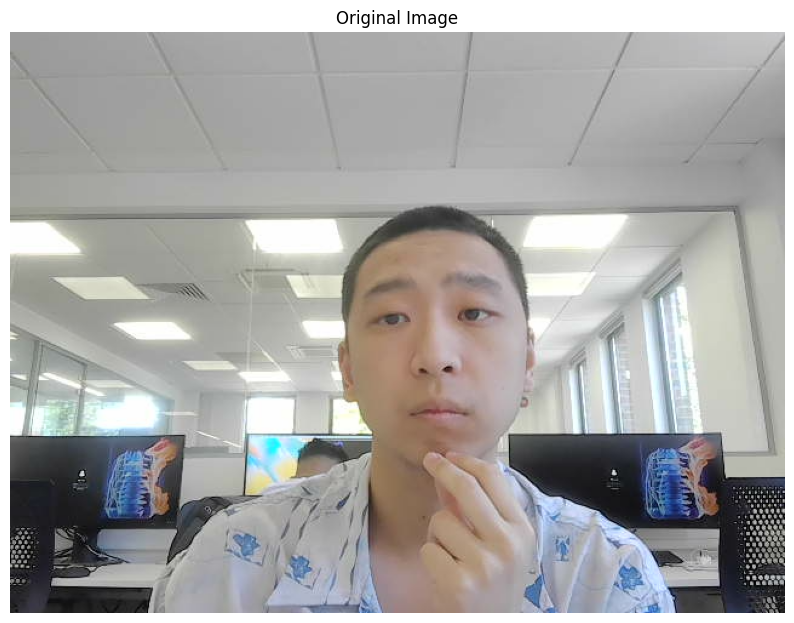

In [3]:
# 'Cell 3: Capture or Load Image'

# 模式选择（交互式输入）
# mode = input("Select mode ('camera' for webcam, 'image' for file): ").strip().lower()
mode = 'camera'  # 直接设置为 'camera' 或 'image' 以便测试
image_bgr = None
capture_time = None

if mode == 'camera':
    # 初始化摄像头
    cap = cv2.VideoCapture(0)  # 默认摄像头（索引0）
    if not cap.isOpened():
        print('Error: Unable to access the webcam.')
    else:
        try:
            # 捕获一帧
            ret, frame = cap.read()
            if ret:
                image_bgr = frame
                capture_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f'Image captured from webcam at {capture_time}.')
                # 保存捕获图像
                os.makedirs('backend/resource', exist_ok=True)
                cv2.imwrite('backend/resource/captured_image.jpg', image_bgr)
                # 保存元数据（时间戳）
                metadata = {"capture_time": capture_time}
                with open(METADATA_PATH, 'w') as f:
                    json.dump(metadata, f)
                print(f'Metadata saved to {METADATA_PATH}.')
            else:
                print('Error: Failed to capture image from webcam.')
        finally:
            cap.release()  # 释放摄像头
elif mode == 'image':
    # 检查文件是否存在
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f'Error: Test image not found at \'{TEST_IMAGE_PATH}\'')
        print('Please place a test image in the project root directory.')
    else:
        # 读取图片 (BGR格式)
        image_bgr = cv2.imread(TEST_IMAGE_PATH)
        print(f'Image \'{TEST_IMAGE_PATH}\' loaded successfully.')
else:
    print('Error: Invalid mode selected. Please choose "camera" or "image".')

# 显示原始图像（如果加载成功）
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
else:
    print('No image loaded.')

In [4]:
# 'Cell 4: Process Image and Describe'

print('Starting the image segmentation pipeline...')
print('This may take a moment as it involves YOLO segmentation.')

# 检查模型和图片是否都已成功加载
if 'yolo_model' in locals() and yolo_model is not None and 'image_bgr' in locals() and image_bgr is not None:
    # 调用核心检测函数
    json_detections, annotated_image_bgr = processing_logic.process_image_and_describe(
        image_bgr,
        yolo_model,
        DEEPSEEK_MODEL_NAME,
        OLLAMA_API_URL,
        capture_time=capture_time
    )
    print('Segmentation complete.')
else:
    print('Skipping segmentation due to errors in previous steps (model or image not loaded).')
    json_detections = json.dumps({"message": "Segmentation failed."})
    annotated_image_bgr = image_bgr  # 仅显示原图（如果有）

Starting the image segmentation pipeline...
This may take a moment as it involves YOLO segmentation.

0: 480x640 2 persons, 1 tv, 2 laptops, 147.8ms
Speed: 2.4ms preprocess, 147.8ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)
Segmentation complete.


Image captured at: 2025-06-30 15:13:39


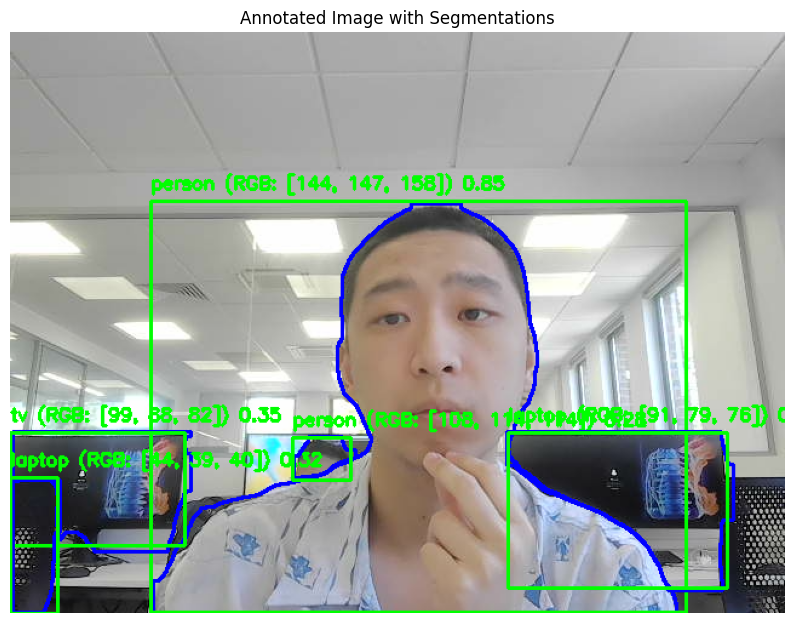

In [5]:
# Cell 5: Display Annotated Image

# 显示拍摄时间（如果适用）
if capture_time:
    print(f"Image captured at: {capture_time}")
else:
    print("No capture time available (image mode).")

# 显示标注图像
if annotated_image_bgr is not None:
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image_rgb)
    plt.title('Annotated Image with Segmentations')
    plt.axis('off')
    plt.show()
else:
    print('No annotated image available.')

In [6]:
# Cell 6: Answer Questions

# 提问循环
while True:
    question = input("Enter your question about the image (or 'quit' to exit): ").strip()
    if question.lower() == 'quit':
        break
    if not question:
        print("Please enter a valid question.")
        continue
    
    print(f"Question: {question}")
    answer = processing_logic.answer_question_with_deepseek(
        json_detections,
        question,
        OLLAMA_API_URL,
        DEEPSEEK_MODEL_NAME
    )
    print(f"Answer: {answer}")
    print("-------------------------------------------------------------------------------------------------------------------------")


Question: what did you see
Answer: Error: Ollama API request timed out.
-------------------------------------------------------------------------------------------------------------------------


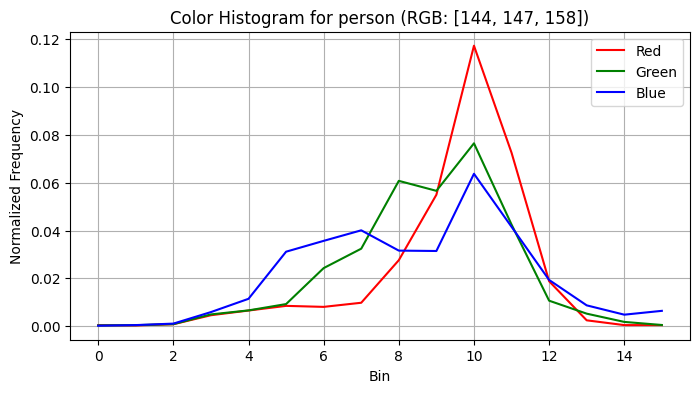

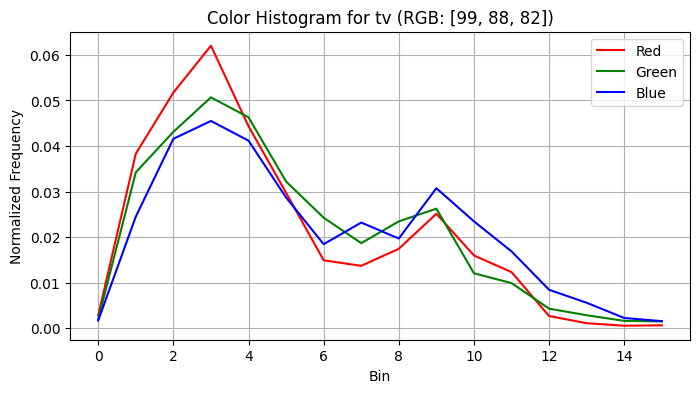

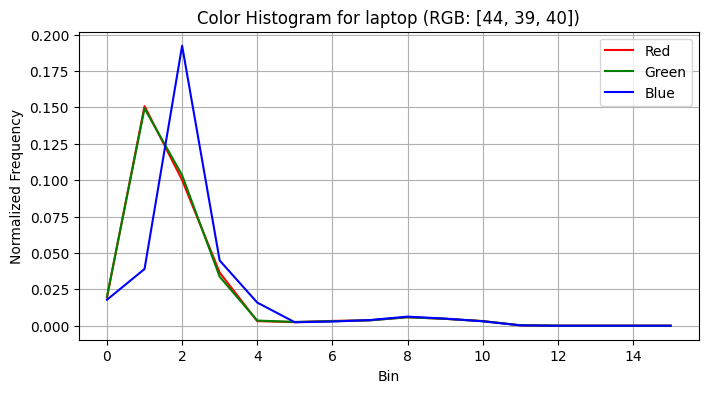

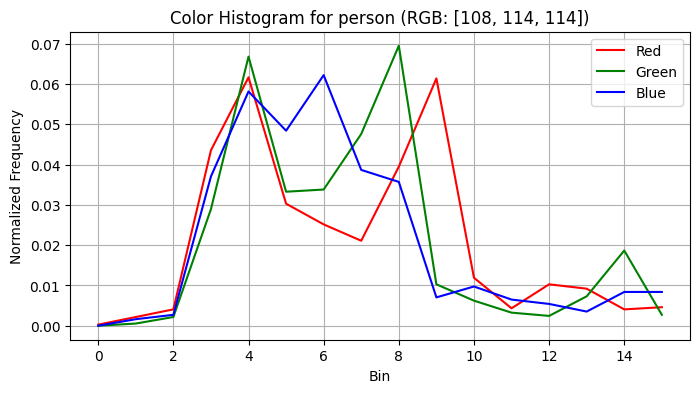

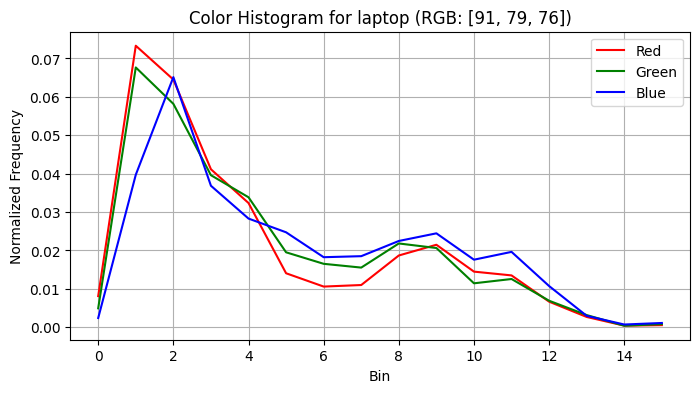

In [7]:
# Cell 7: Display Color Histograms

# 显示颜色直方图
if json_detections:
    detections = json.loads(json_detections)
    if detections.get("detections"):
        for i, detection in enumerate(detections["detections"]):
            class_name = detection["class"]
            rgb = detection["dominant_color_rgb"]
            hist_r = detection["color_histogram"]["r"]
            hist_g = detection["color_histogram"]["g"]
            hist_b = detection["color_histogram"]["b"]
            
            # 绘制直方图
            plt.figure(figsize=(8, 4))
            bins = range(16)
            plt.plot(bins, hist_r, color='red', label='Red')
            plt.plot(bins, hist_g, color='green', label='Green')
            plt.plot(bins, hist_b, color='blue', label='Blue')
            plt.title(f'Color Histogram for {class_name} (RGB: {rgb})')
            plt.xlabel('Bin')
            plt.ylabel('Normalized Frequency')
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("No objects detected, no histograms to display.")
else:
    print("No detection data available.")